# Assignment n°2 - System Benchmarking

## Research method SS23

### Group n°8: 
    -   Grégoire de Lambertye 
    -   add names

## Network creation

### Small netwok

This type of network is characterized by a high degree of clustering and a small average path length between nodes. (E.g., Facebook and Twitter). A virus that spreads quickly through one densely connected group of nodes could have a significant impact on the entire network.

We use Watts-Strogatz method togenerate small-world networks

In [231]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import pandas as pd

# set seed
rd.seed(123)

In [232]:
# Generate Watts-Strogatz model
def generate_watts_strogatz_model(N = 250, K = 4, p = 0.3):
    """"
    input:
        N: Number of nodes
        K: Number of nearest neighbors each node is initially connected to
        p: Probability of rewiring
    output:
        Watts-Strogatz model    
    """
    return(nx.watts_strogatz_graph(N, K, p))

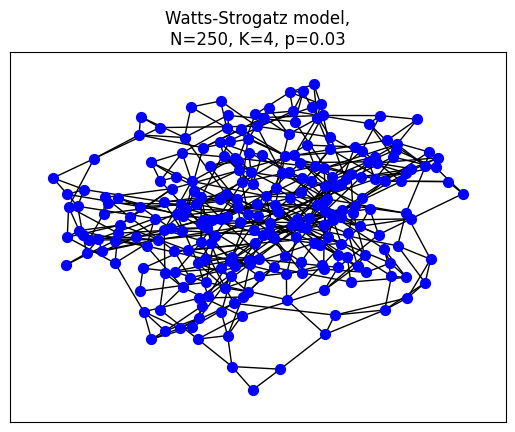

In [233]:
ws_model = generate_watts_strogatz_model()

# Plot the graph
nx.draw_networkx(ws_model, with_labels=False, node_size=50, node_color='b')
plt.title(f"Watts-Strogatz model,\nN={N}, K={K}, p={p:.2f}")
plt.show()

### Scale-free network

This type of network is characterized by a small number of highly connected nodes and many poorly connected nodes. A virus that targets one or more of the hubs in a scale-free network could spread quickly and have a significant impact on the network.

We use Barabasi-Albert model for scale-free networks

In [235]:
# Generate scale-free network using Barabasi-Albert model
def generate_scale_free_network(N = 250, m = 2):
    """"
    input:
        N: Number of nodes
        m: Number of edges to attach from a new node
    output:
        Scale-free network    
    """ 
    return(nx.barabasi_albert_graph(N, m))

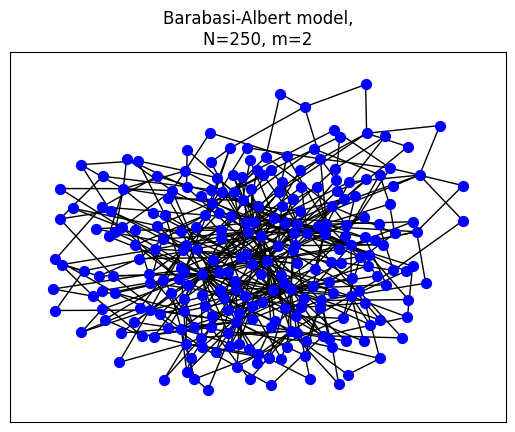

In [236]:
sf_model = generate_scale_free_network()

# Plot the graph
nx.draw_networkx(sf_model, with_labels=False, node_size=50, node_color='b')
plt.title(f"Barabasi-Albert model,\nN={N}, m={m}")
plt.show()

### Community network network

This type of network is characterized by multiple clusters of nodes that are more densely connected to each other than to nodes in other clusters. (E.g., social networks based on geographic location). A virus that spreads quickly through one or more of the tightly connected clusters could have a significant impact on those communities.

We use Lancichinetti-Fortunato-Radicchi (LFR) model for community networks.

In [238]:
# Generate LFR community network
def generate_lfr_community_network(N=250, tau1=2, tau2=1.1, mu=0.1, min_degree=20, max_degree=50):
    """"
    input:
        N: Number of nodes
        tau1: Power law exponent for the degree distribution
        tau2: Power law exponent for the community size distribution
        mu: Fraction of intra-community edges incident to each node
        min_degree: Minimum degree of nodes
        max_degree: Maximum degree of nodes
    output:
        LFR community network
    """
    return(nx.LFR_benchmark_graph(N, tau1, tau2, mu, seed=10, min_degree=min_degree, max_degree=max_degree))

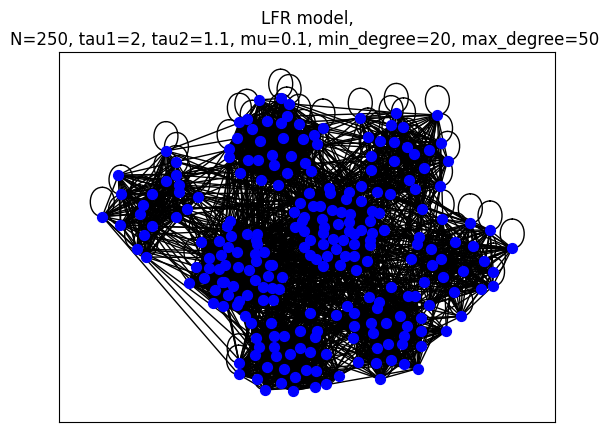

In [239]:
lfr_network = generate_lfr_community_network()

# Plot the graph
nx.draw_networkx(lfr_network, with_labels=False, node_size=50, node_color='b')
plt.title(f"LFR model,\nN={N}, tau1={tau1}, tau2={tau2}, mu={mu}, min_degree={min_degree}, max_degree={max_degree} ")
plt.show()

### Random network

This type of network is characterized by nodes that are connected randomly, with no preferential attachment to other nodes. We will use this as a baseline for the comparison.

In [240]:
# Generate random network
def generate_random_network(N=250, p=0.025):
    """"
    input:
        N: Number of nodes
        p: Probability of edge creation

    output:
        Random network
    """
    return(nx.gnp_random_graph(N, p))

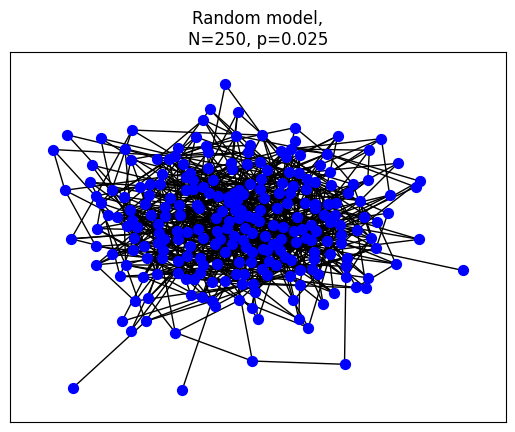

In [241]:
random_network = generate_random_network()

# Plot the graph
nx.draw_networkx(random_network, with_labels=False, node_size=50, node_color='b')
plt.title(f"Random model,\nN={N}, p={p}")
plt.show()

In [242]:
# create a list of all the models generator functions
generator_func = [generate_watts_strogatz_model, generate_scale_free_network, generate_lfr_community_network, generate_random_network]

## Virus simulation

In [341]:
def simulate(network, p_infection, ticks_limit):
    
    experiments_track = pd.DataFrame(columns=["clock", "percent_infected"])

    # Set the number of ticks and initialize the clock
    clock = 0

    # Select a random node as the initially infected node
    infected_node = rd.choice(list(network.nodes()))
    infected_nodes = {infected_node}

    time_infection = dict()
    time_infection[infected_node] = clock

    # Start the simulation
    while len(infected_nodes) < len(network.nodes()) and clock < ticks_limit:        
        new_infections = set()
        
        # Iterate over each infected node
        for node in infected_nodes:
            # Infect neighboring nodes with the given probability
            neighbors = network.neighbors(node)
            for neighbor in neighbors:
                if neighbor not in infected_nodes and rd.random() < p_infection:
                    new_infections.add(neighbor)
                    time_infection[neighbor] = clock
        
        # Add newly infected nodes to the infected set
        infected_nodes.update(new_infections)

        # Add the current state to the dataframe
        perc = len(infected_nodes)*100/len(network.nodes())
        experiments_track.loc[clock] = {'clock': clock, 'percent_infected': perc}
    
        clock = clock+1

    # compute correlation between degree, betweenness, closeness and time of infection
    degree_time = pd.Series(dict(network.degree()).values())
    betweenness_time = pd.Series(nx.betweenness_centrality(network))
    closeness_time = pd.Series(nx.closeness_centrality(network))

    degree_time = degree_time.corr(pd.Series(time_infection))
    betweenness_time = betweenness_time.corr(pd.Series(time_infection))
    closeness_time = closeness_time.corr(pd.Series(time_infection))

    # if clock == ticks_limit:
    #     print("Simulation ended because the ticks limit was reached")
    experiments_track = experiments_track.reset_index()
        
    return experiments_track, degree_time, betweenness_time, closeness_time


In [342]:
def benchmark_network(network, n_simu = 100, p_infection = 0.3, ticks_limit = 150):
    experiments_tracks = pd.DataFrame(columns=["clock", "percent_infected"])
    degree_times = []
    betweenness_times = []
    closeness_times = []
    for i in range(n_simu):
        experiments_track, degree_time, betweenness_time, closeness_time = simulate(network, p_infection, ticks_limit)
        experiments_tracks = pd.concat([experiments_tracks, experiments_track], ignore_index=True)
        degree_times.append(degree_time)
        betweenness_times.append(betweenness_time)
        closeness_times.append(closeness_time)
    experiments_tracks = experiments_tracks.groupby(["clock"]).mean()
    experiments_tracks = experiments_tracks.reset_index()
    
    return experiments_tracks, np.mean(degree_times), np.mean(betweenness_times), np.mean(closeness_times)


In [343]:
def benchmark_network_type(genrate_function, n_simu=100, n_network=100, p_infection = 0.3, ticks_limit = 150):
    experiments_tracks = pd.DataFrame(columns=["clock", "percent_infected"])
    degree_times = []
    betweenness_times = []
    closeness_times = []
    for i in range(n_network):
        network = genrate_function()
        experiments_track, degree_time, betweenness_time, closeness_time = benchmark_network(network, n_simu, p_infection, ticks_limit)
        experiments_tracks = pd.concat([experiments_tracks, experiments_track], ignore_index=True)
        degree_times.append(degree_time)
        betweenness_times.append(betweenness_time)
        closeness_times.append(closeness_time)

    experiments_tracks = experiments_tracks.groupby(["clock"]).mean()
    experiments_tracks = experiments_tracks.reset_index()

    return experiments_tracks, np.mean(degree_times), np.mean(betweenness_times), np.mean(closeness_times)

In [344]:
#set seed 
rd.seed(123)

experiments_tracks = pd.DataFrame(columns=["clock", "model", "percent_infected"])
correlation = pd.DataFrame(columns=["model", "degree_time", "betweenness_time", "closeness_time"])
correlation.set_index("model", inplace=True)

for generator in generator_func:
    experiments_track, degree_time, betweenness_time, closeness_time = benchmark_network_type(genrate_function=generator, n_simu=5, n_network=10, p_infection = 0.1)
    experiments_track["model"] = generator.__name__
    experiments_tracks = pd.concat([experiments_tracks, experiments_track], ignore_index=True)
    correlation.loc[generator.__name__] = [degree_time, betweenness_time, closeness_time]

experiments_tracks = experiments_tracks.drop(columns=["index"])


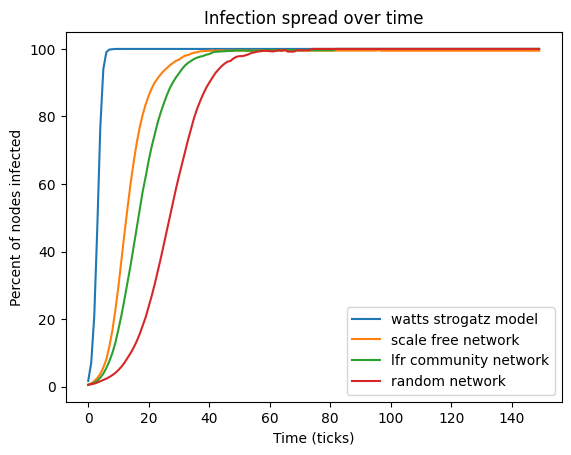

                                degree_time  betweenness_time  closeness_time
model                                                                        
generate_watts_strogatz_model     -0.175092         -0.202245       -0.280076
generate_scale_free_network       -0.264217         -0.226557       -0.364637
generate_lfr_community_network    -0.298643         -0.166721       -0.297770
generate_random_network           -0.341232         -0.285900       -0.374633


In [352]:
# add value for all ticks for each model (100% infected)

max_clock = experiments_tracks["clock"].max()
for generator in generator_func:
    for clock in range(max_clock, 0, -1):
        if clock not in experiments_tracks[experiments_tracks["model"] == generator.__name__]["clock"].values:
            new_row = pd.DataFrame([[clock, generator.__name__, 100]], columns=["clock", "model", "percent_infected"])
            experiments_tracks = pd.concat([experiments_tracks, new_row], ignore_index=True)
        else :
            break

experiments_tracks.reset_index().pivot(index="clock", columns="model", values="percent_infected").plot()
plt.legend([name[9:].replace("_", " ") for name in experiments_tracks["model"].unique()])
plt.title("Infection spread over time")
plt.ylabel("Percent of nodes infected")
plt.xlabel("Time (ticks)")
plt.show()

print(correlation)

### old experience

In [346]:


# parameters
p_infection = 0.05  # Probability of infection per tick
model_names = ["ws_model", "sf_model", "lfr_network", "random_network"] # Names of the models
ticks = 100  # Number of ticks to run the simulation for
count = 0 # Counter for the model names

experiments_track = pd.DataFrame(columns=["clock", "model", "infected_nodes", "percent_infected"])
experiments_track.set_index(["clock", "model"], inplace=True)

for network in models:
    
    # Select a random node as the initially infected node
    infected_node = rd.choice(list(network.nodes()))
    infected_nodes = {infected_node}

    # Set the number of ticks and initialize the clock
    clock = 0

    # Start the simulation
    while clock < ticks:        
        new_infections = set()
        
        # Iterate over each infected node
        for node in infected_nodes:
            # Infect neighboring nodes with the given probability
            neighbors = network.neighbors(node)
            for neighbor in neighbors:
                if neighbor not in infected_nodes and rd.random() < p_infection:
                    new_infections.add(neighbor)
        
        # Add newly infected nodes to the infected set
        infected_nodes.update(new_infections)

        # Add the current state to the dataframe
        perc = len(infected_nodes)*100/len(network.nodes())
        # print(clock)
        if not experiments_track.index.isin([(clock, str(model_names[count]))]).any():
            experiments_track.loc[(clock, str(model_names[count])), :] = [infected_nodes.copy(), perc]
        else:
            print("Line already exists _error :", str(model_names[count]), "clock:", clock)

        clock = clock+1
        
    count += 1

# Spread visualisation

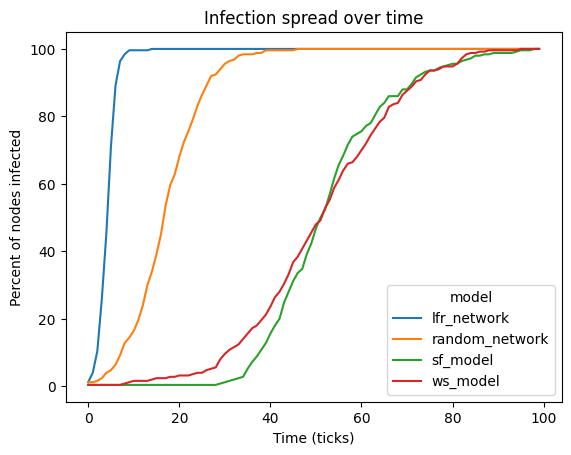

In [347]:
experiments_track.reset_index().pivot(index="clock", columns="model", values="percent_infected").plot()
plt.title("Infection spread over time")
plt.ylabel("Percent of nodes infected")
plt.xlabel("Time (ticks)")
plt.show()

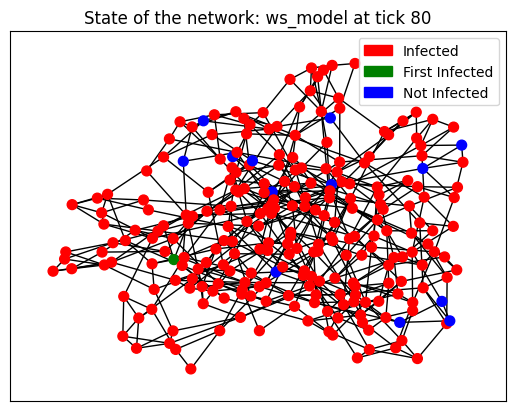

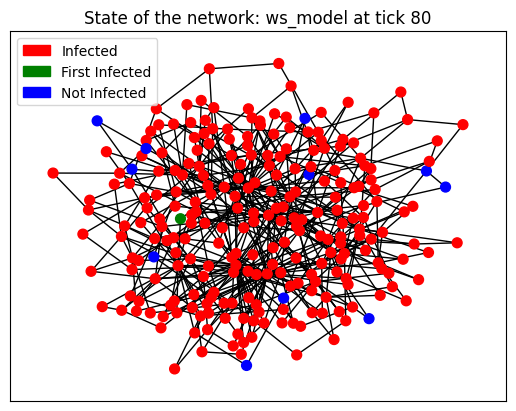

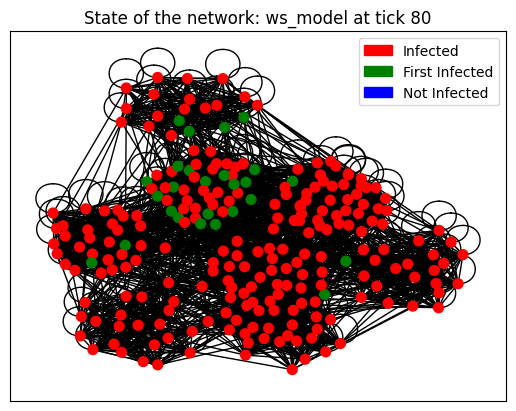

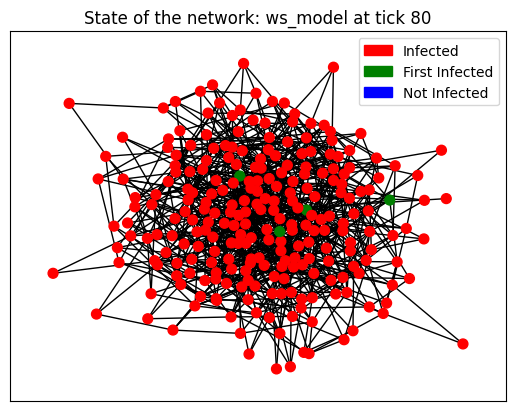

In [348]:
from matplotlib import patches


for i in range(len(models)):
    network = models[i]
    infected_node = experiments_track.loc[(80, str(model_names[i])),"infected_nodes"]
    first_infected_node = experiments_track.loc[(2, str(model_names[i])),"infected_nodes"]

    color_map = []
    for node in G:
        if node in infected_node:
            if node in first_infected_node:
                color_map.append('green')
            else:
                color_map.append('red')
        else: 
            color_map.append('blue')      
    nx.draw_networkx(network, with_labels=False, node_size=50, node_color=color_map)
    plt.title(f"State of the network: {model_names[0]} at tick 80")
    red_patch = patches.Patch(color='red', label='Infected')
    green_patch = patches.Patch(color='green', label='First Infected')
    blue_patch = patches.Patch(color='blue', label='Not Infected')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    plt.show()

Daria Stefan16:22
a.	Identifying the most vulnerable positions in each network
Measures:
•	Time until infection
•	Centrality (degree, betweenness, closeness)
b.	determining the resilience of each type of network in case of the event
Measures:
•	Number of infected nodes in a certain time
•	Time it takes for the whole network to be infected.
Daria Stefan16:43
for each network
for each node
calc 3 centralities and time to infection
Daria Stefan16:44
correlation coeff between the three centralities and time till infection